<a href="https://www.kaggle.com/code/kaif444/bfsi-hackthon?scriptVersionId=236338777" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Step 2: Load Dataset
df = pd.read_csv('/kaggle/input/german-credit-dataset/german_credit_data (1).csv')
print(df.head())
print(df.info())

   Unnamed: 0  Age     Sex  Job Housing Saving accounts Checking account  \
0           0   67    male    2     own             NaN           little   
1           1   22  female    2     own          little         moderate   
2           2   49    male    1     own          little              NaN   
3           3   45    male    2    free          little           little   
4           4   53    male    2    free          little           little   

   Credit amount  Duration              Purpose  Risk  
0           1169         6             radio/TV  good  
1           5951        48             radio/TV   bad  
2           2096        12            education  good  
3           7882        42  furniture/equipment  good  
4           4870        24                  car   bad  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unna

In [3]:
# Step 3: Data Preprocessing

# Handling Missing Values
df['Saving accounts'] = df['Saving accounts'].fillna('no_info')
df['Checking account'] = df['Checking account'].fillna('no_info')

# Encoding Categorical Variables
cat_cols = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Feature Scaling
scaler = StandardScaler()
X = df_encoded.drop('Risk', axis=1)
y = df_encoded['Risk'].map({'good':0, 'bad':1})  # good=0 (no default), bad=1 (default)

X_scaled = scaler.fit_transform(X)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [4]:
def evaluate_model(model, model_name):
    y_pred = model.predict(X_test)
    print(f"\n--- {model_name} Classification Report ---\n")
    print(classification_report(y_test, y_pred))
    
    print(f"\n--- {model_name} Confusion Matrix ---\n")
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.show()
    
    y_pred_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0,1], [0,1], linestyle='--')
    plt.title(f'ROC Curve - {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    
    with open(f'{model_name.lower().replace(" ", "_")}_model.pkl', 'wb') as f:
        pickle.dump(model, f)


--- Logistic Regression Classification Report ---

              precision    recall  f1-score   support

           0       0.77      0.89      0.83       140
           1       0.59      0.37      0.45        60

    accuracy                           0.73       200
   macro avg       0.68      0.63      0.64       200
weighted avg       0.72      0.73      0.71       200


--- Logistic Regression Confusion Matrix ---



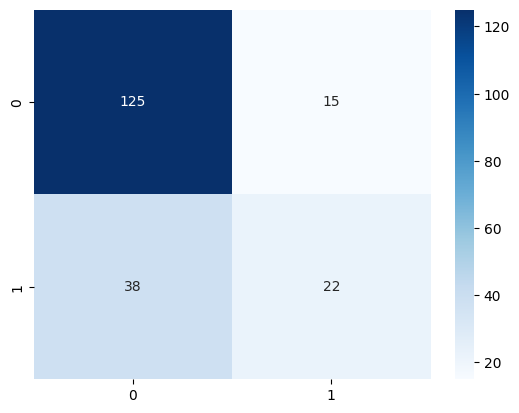

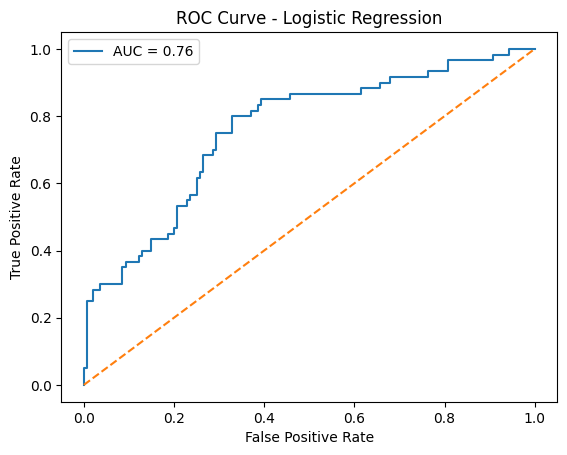

In [5]:
# Step 5.1: Logistic Regression
logreg = LogisticRegression(max_iter=1000)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}
grid_logreg = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_logreg.fit(X_train, y_train)

evaluate_model(grid_logreg.best_estimator_, "Logistic Regression")


--- Decision Tree Classification Report ---

              precision    recall  f1-score   support

           0       0.71      0.93      0.80       140
           1       0.38      0.10      0.16        60

    accuracy                           0.68       200
   macro avg       0.54      0.51      0.48       200
weighted avg       0.61      0.68      0.61       200


--- Decision Tree Confusion Matrix ---



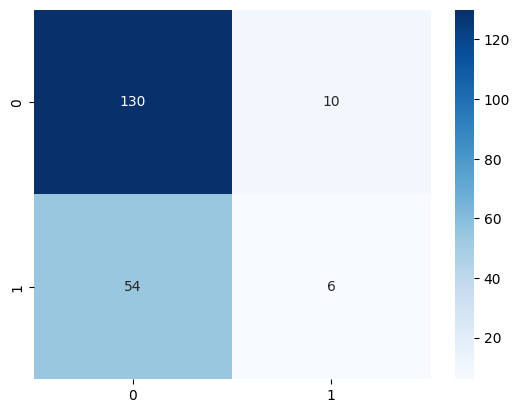

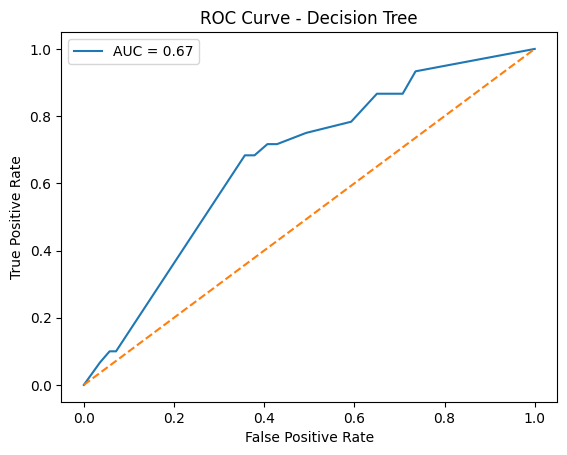

In [6]:
# Step 5.2: Decision Tree
dtree = DecisionTreeClassifier(random_state=42)
param_grid = {
    'max_depth': [3, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}
grid_dtree = GridSearchCV(dtree, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_dtree.fit(X_train, y_train)

evaluate_model(grid_dtree.best_estimator_, "Decision Tree")


--- Random Forest Classification Report ---

              precision    recall  f1-score   support

           0       0.79      0.95      0.86       140
           1       0.77      0.40      0.53        60

    accuracy                           0.79       200
   macro avg       0.78      0.68      0.69       200
weighted avg       0.78      0.79      0.76       200


--- Random Forest Confusion Matrix ---



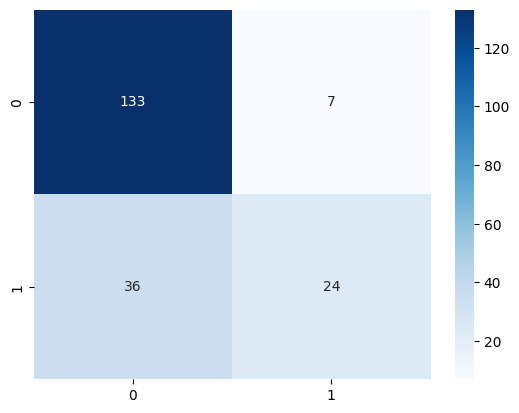

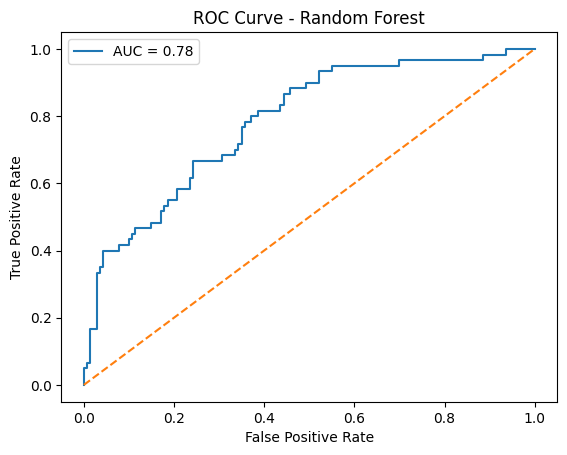

In [7]:
# Step 5.3: Random Forest
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10]
}
grid_rf = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)

evaluate_model(grid_rf.best_estimator_, "Random Forest")


--- XGBoost Classification Report ---

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       140
           1       0.64      0.50      0.56        60

    accuracy                           0.77       200
   macro avg       0.72      0.69      0.70       200
weighted avg       0.75      0.77      0.76       200


--- XGBoost Confusion Matrix ---



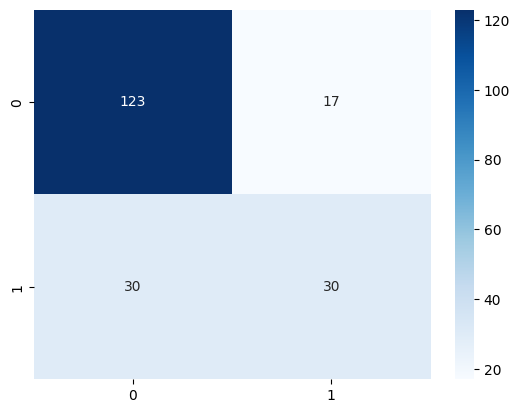

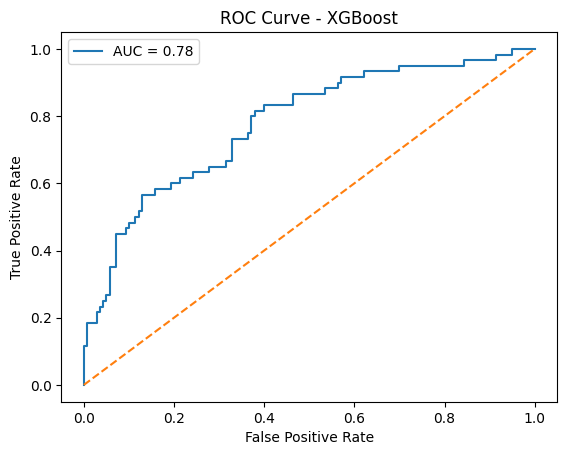

In [8]:
# Step 5.4: XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
grid_xgb = GridSearchCV(xgb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_xgb.fit(X_train, y_train)

evaluate_model(grid_xgb.best_estimator_, "XGBoost")


--- CatBoost Classification Report ---

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       140
           1       0.65      0.47      0.54        60

    accuracy                           0.77       200
   macro avg       0.72      0.68      0.69       200
weighted avg       0.75      0.77      0.75       200


--- CatBoost Confusion Matrix ---



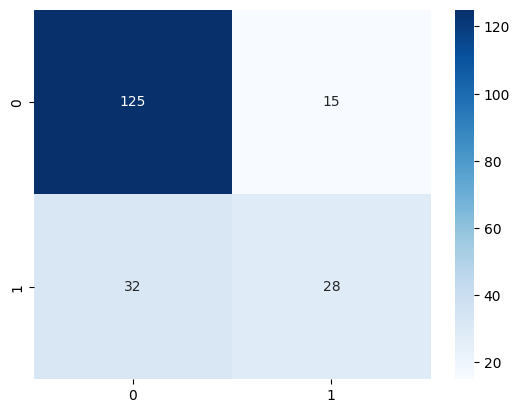

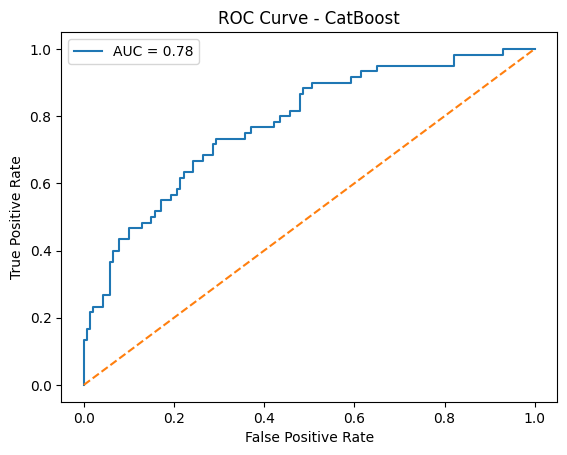

In [9]:
# Step 5.6: CatBoost
catboost = CatBoostClassifier(verbose=0, random_state=42)
param_grid = {
    'iterations': [100, 200],
    'learning_rate': [0.01, 0.1],
    'depth': [3, 5, 7]
}
grid_catboost = GridSearchCV(catboost, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_catboost.fit(X_train, y_train)

evaluate_model(grid_catboost.best_estimator_, "CatBoost")


--- K-Nearest Neighbors Classification Report ---

              precision    recall  f1-score   support

           0       0.75      0.86      0.80       140
           1       0.50      0.33      0.40        60

    accuracy                           0.70       200
   macro avg       0.62      0.60      0.60       200
weighted avg       0.68      0.70      0.68       200


--- K-Nearest Neighbors Confusion Matrix ---



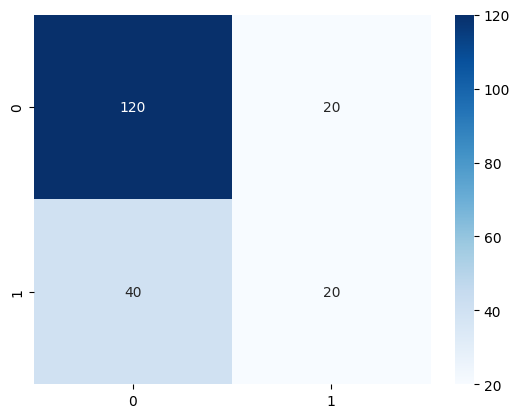

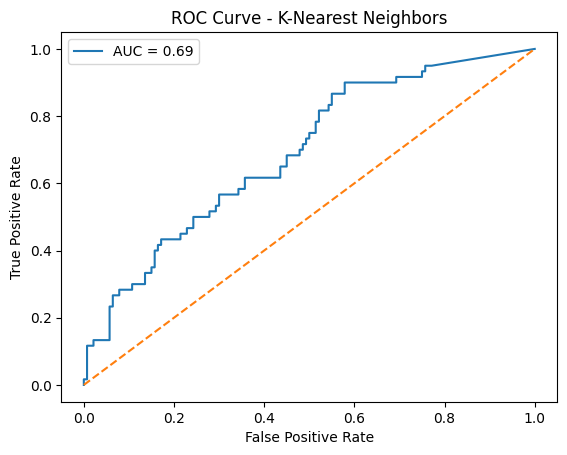

In [10]:
# Step 5.7: KNN
knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'euclidean']
}
grid_knn = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_knn.fit(X_train, y_train)

evaluate_model(grid_knn.best_estimator_, "K-Nearest Neighbors")

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.95      0.86       140
           1       0.77      0.40      0.53        60

    accuracy                           0.79       200
   macro avg       0.78      0.68      0.69       200
weighted avg       0.78      0.79      0.76       200

ROC AUC Score: 0.7841666666666666
F1 Score: 0.5274725274725275


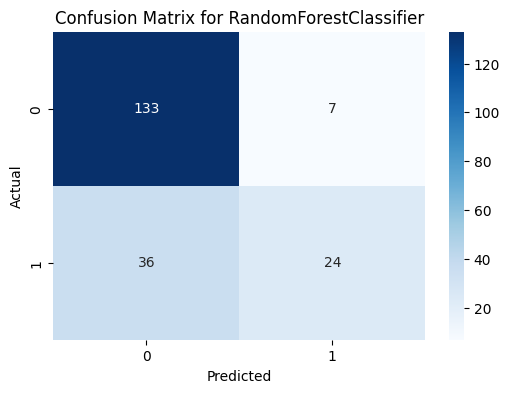

In [11]:
# Assuming you want to evaluate Random Forest (change best_model assignment accordingly)

# After GridSearchCV training:
best_model = grid_rf.best_estimator_

# Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions
y_pred = best_model.predict(X_test)

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# ROC AUC Score
roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1])
print("ROC AUC Score:", roc_auc)

# F1 Score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix for {best_model.__class__.__name__}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [12]:
from sklearn.model_selection import cross_val_score

# 5-fold cross-validation
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

Cross-Validation Scores: [0.735 0.72  0.745 0.75  0.745]
Mean CV Accuracy: 0.7390000000000001


In [13]:
import joblib

# Assuming best_model is already defined (e.g., after GridSearchCV)
best_model = grid_rf.best_estimator_  # Or any other model you selected

# Save the model to a file using joblib
joblib.dump(best_model, 'credit_risk.pkl')

print("Model saved as credit_risk.pkl")

Model saved as credit_risk.pkl


In [14]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib

# Load your dataset (make sure to replace with your actual file path)
data = pd.read_csv('/kaggle/input/german-credit-dataset/german_credit_data (1).csv')

# Prepare data for modeling
X = data.drop(['Risk'], axis=1)  # Drop target column
y = data['Risk']  # Target variable

# Convert categorical variables to numerical using one-hot encoding
X = pd.get_dummies(X, drop_first=True)

# Fill missing values with the mode (most frequent value) of each column
X.fillna(X.mode().iloc[0], inplace=True)

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Evaluate the model's accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

# Save the trained model using joblib
joblib.dump(model, 'credit_risk.pkl')
print("Model saved as credit_risk.pkl")  #Random Forest Model saved

Accuracy: 0.705
Model saved as credit_risk.pkl
